<a href="https://colab.research.google.com/github/pedr19faria/Molecular-Dynamics/blob/main/Mol_Dyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Importing all needed functions
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import animation
from matplotlib.animation import PillowWriter
from itertools import combinations
from numpy import random


####**The Lennerd-Jones Potential**
The Lennard-Jones (LJ) potential is a potential function that provides the two principal features of interatomic force, which are a repulsive force at close ranges and an attratiction at bigger ranges between two atoms.This function can be described as the following: \
$u(r_{ij}) = \begin{cases} 4ɛ[(\dfrac{\sigma}{r_{ij}})^{12} - (\dfrac{\sigma}{r_{ij}})^{6}] & r_{ij} < r_c \\ 0 & r_{ij} ≥ r_c \end{cases}$ \
ɛ and σ are parameters, the former governing the strength of the interaction and the latter defining the length scale. In this simulation, however, we will use dimensionless units, simplifying the physical quantities, so throughtout the simulation ɛ and σ will be equal to 1. From the graph there are some important considerantions to be taken. Before the deep well, which happens at $r = 2^{1/6}σ = 1.1225$, in dimensionless units, the forces between two particles will be repulsive and after it they will be atractive (this can be seen by calculating the derivative of the energy). 


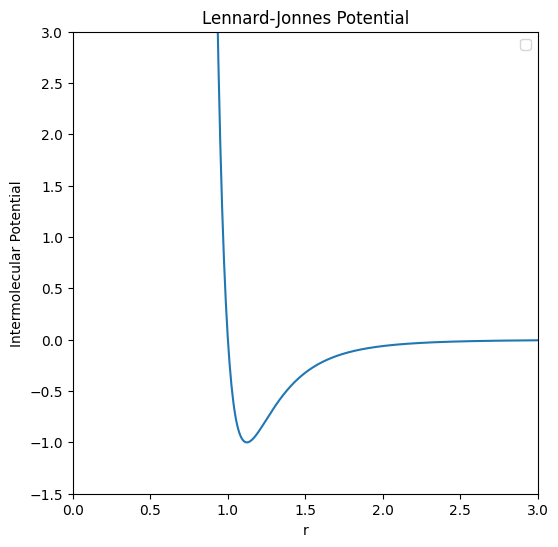

In [8]:
r = np.linspace(0.01, 3., 500)
lj = 4*((1/r)**(12) - (1/r)**(6))

plt.figure(figsize = (6,6))
plt.plot()
plt.xlim(0., 3.)
plt.ylim(-1.5, 3.)
plt.title('Lennard-Jonnes Potential')
plt.plot(r,lj)
plt.axhline(0., linestyle = '--', c = 'g', label = 'Minimiun potential = (1.1225, -1)')
plt.axvline(1.1225, linestyle = '--', c = 'g')
plt.legend()

In [112]:

### Calculate velocities with a Gaussian Distribution at mean 0 and deviation according to Maxwell Distribution.
def velocities(number_atoms, dimension, k = 1, T = 1, m = 1):
  deviation = np.sqrt(k*T/m)
  return np.random.normal(loc = 0., scale = deviation, size = (dimension, number_atoms))
    #Example: if dimensions = 2:
    #vel[0] gives the velocities in x
    #vel[1] gives the velocities in y


In [70]:
def position(num_points):
    """
    Generates points distributed in a square shape.

    Args:
        num_points (int): Number of points to generate.
        side_length (float): Length of the square's side.

    Returns:
        np.ndarray: 2-dimensional array of points with shape (num_points, 2).
    """
    side_length = np.sqrt(num_points)
    # Calculate the number of points per side of the square
    points_per_side = int(np.sqrt(num_points))

    # Calculate the spacing between points on each side
    spacing = side_length / (points_per_side - 1)

    # Generate points along x-axis and y-axis
    x_points = np.linspace(-side_length / 2, side_length / 2, points_per_side)
    y_points = np.linspace(-side_length / 2, side_length / 2, points_per_side)

    # Create a 2-dimensional grid of points
    X, Y = np.meshgrid(x_points, y_points)
    points = np.vstack([X.ravel(), Y.ravel()])

    return points

In [184]:
N_atoms = 14**2
dim = 2

p = position(N_atoms)
v = velocities(N_atoms, dim)
force = np.zeros((N_atoms, dim))

In [61]:
p.shape

(2, 196)

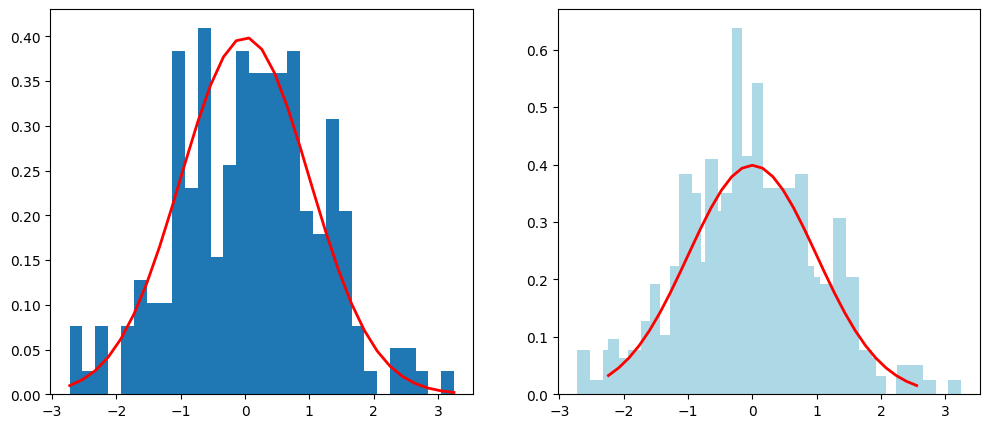

In [185]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
ax[0].hist(v[0], bins = 30, density = True)
count, bins, ignored = plt.hist(v[0], 30, density=True, color = 'lightblue')
ax[0].plot(bins, 1/(np.sqrt(2 * np.pi)) *
               np.exp( - (bins)**2 / (2) ),
         linewidth=2, c = 'r')
ax[1].hist(v[1], bins = 30, density = True)
count2, bins2, ignored2 = plt.hist(v[1], 30, density=True, color = 'lightblue')
ax[1].plot(bins2, 1/(np.sqrt(2 * np.pi)) *
               np.exp( - (bins2)**2 / (2) ),
         linewidth=2, c = 'r')
plt.show()

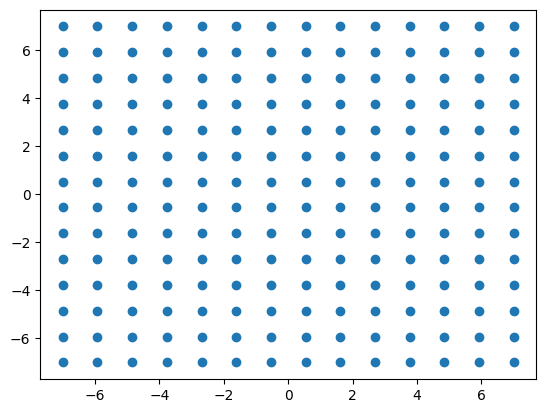

In [186]:
plt.scatter(p[0], p[1])
plt.show()

####**Periodic Boundary Conditions**
A very important concept to the implemantation of this MD simulation is the use of periodic boundary conditions. This makes it that the simulation is free of rifid walls, but it is still bounded, it is as if there were infinite space, with identical copies of the simulation region. This can also be thought as putting this region in a torus, so the physical boundaries cease to exist. There are 2 main consequences to this fact. First of all, the atoms that leave the simulation will enter it immediatley once again, but in the other side of the wall (just like in the game Pac-Man). Also, a wraparound effect will need to be considered, in order for the equation of motion and the interaction between the "atoms" to work. In this case after each step the coordinates are examined and if one of the atoms has moved outside of the limits of the box it will be brought back to its side so when calculating the interatomic effect on each pair this is not be ignored.  
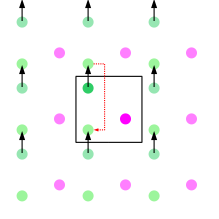 \


The functions below calculate the forces between every two particles. The force is calculated using the formula: \
$f_{ij} = (\dfrac{48ɛ}{σ^2})[(\dfrac{σ}{r_{ij}})^{14} - \dfrac{1}{2}(\dfrac{\sigma}{r_{ij}})^8]r_{ij}$ \
Once again, this is the force only when $r_{ij} < r_c$ and zero otherwise. Alson, since Newton's third law affirms that $f_{ij} = -f_{ji}$ every pair of atoms is only iterated once. 

In [161]:
### Force of Particle 1 on Particle 2:
def Force12(r): # r is a scalar
  r12 = (1/r)**6
  r6 = (1/r)**3

  force = (24/r)*(2*r12 - r6)

  return force

def Calc_Force(pos, force, N_atoms, rcut, L):
  force = force.T
  pos = pos.T
  force = force*0.

  for i in range(N_atoms-1):
    for j in range(i+1, N_atoms):
      # Distance of atoms:

      r = pos[i,:] - pos[j,:]  ### Subtraction of ([xi,yi] - [xj,yj])
      ### Periodic Boundaries:
      for i in range(r.shape[0]):
        if (np.abs(r[i])>0.5*L):
          r[i] = r[i] - np.copysign(1.0,r[i])*L
      rij = r
      rmij = np.linalg.norm(rij)
      
      if (rmij < rcut**2):
        force[i,:] = Force12(rmij) * r
        force[j,:] = -Force12(rmij) * r # Fij = -Fji 
  return force

In order to advance the simulation the **Velocity-Verlet Algorithm** is used. The implementation of the algorithm is in the following way:


1.   $v_i(t + Δt/2) = v_i(t) + a_i(t)(\dfrac{Δt}{2})$
2.   $r_i(t + h) = r_i(t) + v(t + \dfrac{Δt}{2})Δt$
3.   Compute the accelaration (Force) using the Calc_Force() function
4.   $v_i(t + Δt) = v_i(t + Δt/2) + a(t + Δt)(\dfrac{Δt}{2}) $ \

So by the end of this algorithm it will be returned the new positions and velocities. \
It has a big advantadge of calculating velocity and position simultaneously. \
OBS.: In this simulation $m = 1.$, so since $F = ma$ (Newton's 2nd Law), $a = F$.


In [162]:
def velocity_verlet(pos, v, force, N_atoms, time, dt, L, dim=2):

  vel_time = np.zeros((time, dim, N_atoms))
  post = np.zeros((time,dim, N_atoms))
  force_time = np.zeros((time, dim, N_atoms))
  vel_time[0] = v.copy()
  post[0] = pos.copy()
  force = force.T
  force_time[0] = force.copy()
  ## pos is an 2d array pos[0] em x e pos[1] em y
  for i in range(time):
    for k in range(N_atoms):
      #Periodic Boundaries:
      pos[np.where(pos >= L/2)] -= L
      pos[np.where(pos <-L/2)] += L
    if force.shape != pos.shape:
      force = force.T
    
    v +=  (1/2)*force*dt
    pos += v*dt + (1/2)*(dt**2)*force
    
    
    force = Calc_Force(pos, force, N_atoms, rcut, L)
    if force.shape != v.shape:
      force = force.T   

    v += (1/2)*force*dt

    if i != 0:
      post[i] = pos.copy()
      vel_time[i]= v.copy()
      force_time[i] = force.copy()

    
  return  force, post, vel_time

In [187]:
time = 500
dt = 0.0001
rcut = 2.5 
L = np.sqrt(N_atoms)
f_f, pos_f, vel_f = velocity_verlet(p, v, force, N_atoms, time,dt, L)


Text(0.5, 1.0, 'Final positions of atoms')

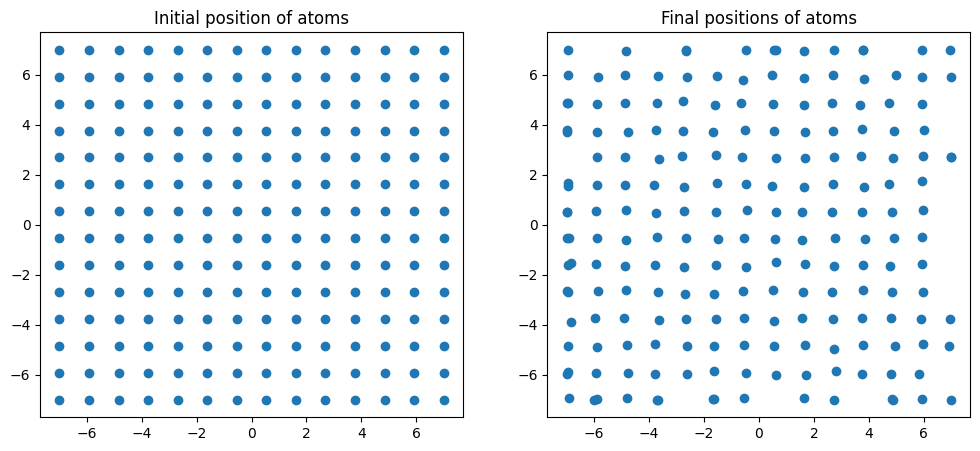

In [188]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
ax[0].scatter(pos_f[0][0], pos_f[0][1])
ax[0].set_title('Initial position of atoms')
ax[1].scatter(pos_f[-1][0], pos_f[-1][1])
ax[1].set_title('Final positions of atoms')

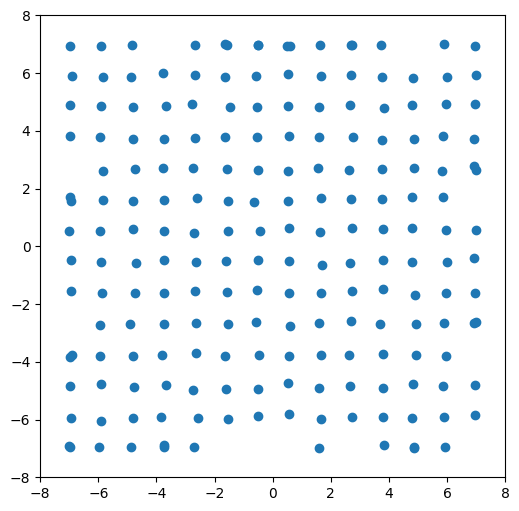

In [23]:
fig, ax = plt.subplots(figsize=(6,6))

def animate(i):
  ax.clear()
  ax.scatter(pos_f[i][0], pos_f[i][1])
  ax.set_xlim(-L/2 -1,L/2+1)
  ax.set_ylim(-L/2-1 ,L/2+1)   
plt.title('Atoms positions')
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('ani_parti.gif',writer='pillow',fps=12)

####**The Maxwell-Boltzmann Distribution** 
The Maxwell-Boltzmann Distribution gives us the distribution of molecular speed. \
$f(v) = 4πv^2(\dfrac{m}{2\pi k_bT})^{3/2}e^{({\dfrac{-mv^2}{2k_bT}})}$ \
Since we are using dimensionless units $m=1$, $k_b = 1$, $T = 1$. By the histogram plotted below it is possible to observe that the speeds do approach the Maxwell-Boltzmann Distribution function as the time passes, this is better observed on the animation.

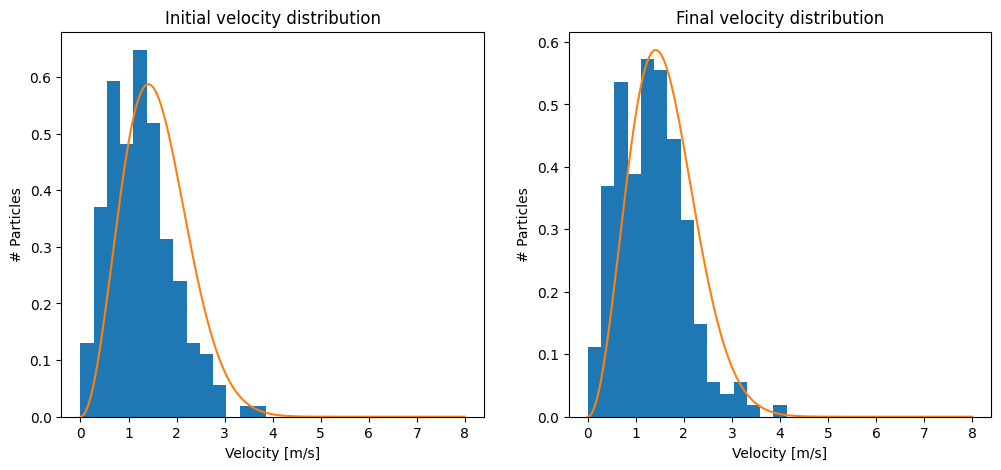

In [212]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
bins = np.linspace(0., 8.,30)
vh = np.linspace(0., 8., 500)
f = 4*np.pi*(vh**2.)*(1/(np.sqrt((2*np.pi)**3)))*np.exp((-vh**2)/2)
ax[0].hist(np.sqrt(np.sum(vel_f[0]**2, axis = 0)), bins = bins, density = True)
ax[0].plot(vh,f)
ax[0].set_xlabel('Velocity [m/s]')
ax[0].set_ylabel('# Particles')
ax[0].set_title('Initial velocity distribution')

ax[1].hist(np.sqrt(np.sum(vel_f[-1]**2, axis = 0)), bins = bins, density = True)
ax[1].plot(vh,f)
ax[1].set_title('Final velocity distribution')
ax[1].set_xlabel('Velocity [m/s]')
ax[1].set_ylabel('# Particles')
plt.show()

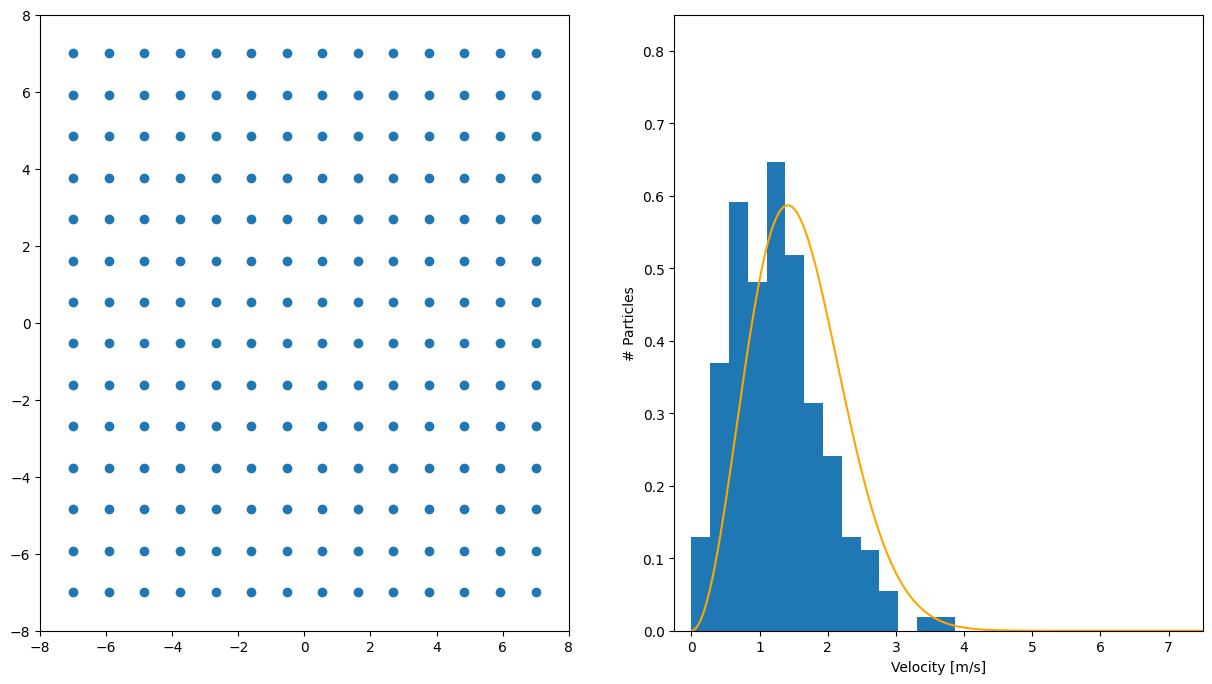

In [213]:
fig, ax = plt.subplots(1,2, figsize = (15,8))

def animate(i):
  [ax.clear() for ax in ax]
  ax1 = ax[0]
  ax2 = ax[1]
  ax1.scatter(pos_f[i][0], pos_f[i][1])
  ax1.set_xlim(-L/2 - 1,L/2 + 1)
  ax1.set_ylim(-L/2 - 1 ,L/2 + 1)  
  ax2.hist(np.sqrt(np.sum(vel_f[i]**2, axis=0)), bins=bins, density=True)
  ax2.plot(vh,f, c='orange')
  ax2.set_xlabel('Velocity [m/s]')
  ax2.set_ylabel('# Particles')
  ax2.set_xlim(-0.25, 7.5)
  ax2.set_ylim(0,0.85)






ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('ani_2.gif',writer='pillow',fps=12)